# FOM - Anwendungsfelder der Business Analytics am Beispiel von Fraud Detection im von Kreditkartentransaktionen

In diesem Jupyter Notebook soll der nicht-überwachte K-Means Algorithmus für das vollautomatische Clustering von Kreditkartentransaktionen verwendet werden. Dieser K-Means Algortihmus soll auf den in einer Kreditkartentransaktion bezahlten Geldbetrag angewandt werden, sodass im Anschluss geprüft werden kann, zu welchem Cluter eine Kreditkarte gehört. Mit diesem Vorgehen kann das Verwendungsprofil einer Kreditkarte identifiziert werden.

<b>Für dieses Vorhaben werden folgende Schritte unternommen:</b>
1. Import aller benötigten Python Packages
2. Laden der Daten aus dem AWS S3 Bucket
3. Erstellen eines DataFrames unter Verwendung von Pandas
4. Die obersten Werte der Daten anzeigen
5. Scatter Plot der Daten erstellen und ggf. Ausreiser entfernen

Im folgenden wird mit dem Import alles benötigten Python Packages begonnen.

In [1]:
# import python packages required for k-means-clustering
import os
import io
import boto3
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sagemaker import KMeans, get_execution_role

## Bereitstellen der Daten

Daran anschließend werden zunächst die benötigten Trainings Daten importiert. Da diese in einem S3 Bucket gehalten werden, muss zunächst der <code>Boto3 Client</code> initialisiert werden.

In [2]:
s3_client = boto3.client('s3')
bucket_name = 'anwendungsfelder-big-data-fraud-detection-ieee-cis-data-set'

Der S3 Client wird nun für die Erstellung einer Liste aller in dem S3 Bucket enthaltenden Elemente verwendet.

In [3]:
obj_list = s3_client.list_objects(Bucket=bucket_name)
for element in obj_list:
    print(element)

ResponseMetadata
IsTruncated
Marker
Contents
Name
Prefix
MaxKeys
EncodingType


Da der Inhalt benötigt wird, wird im folgenden der Key <code>Contents</code> betrachtet.

In [6]:
i = 0
for content_element in obj_list['Contents']:
    print("{}: {}".format(str(i), content_element['Key']))
    i += 1

0: data/
1: data/ieee_cis_train_cropped/
2: data/ieee_cis_train_cropped/Definite+cropped+ieeecis+data/2020/01/20/95edc928-d16f-4c73-9c76-0c6b03e7b2a2.csv.metadata
3: data/ieee_cis_train_cropped/Definite+cropped+ieeecis+data/2020/01/20/final_cropped_data.csv
4: data/ieee_cis_train_cropped/Unsaved/2020/01/18/63c36171-c759-4f56-bbc6-923798bacddf.csv.metadata
5: data/ieee_cis_train_cropped/Unsaved/2020/01/18/train_cropped_transaction_identity.csv
6: data/ieee_cis_train_cropped/Unsaved/2020/01/23/6ba463b9-2d56-41c9-8475-dd6458a22f11.csv
7: data/ieee_cis_train_cropped/Unsaved/2020/01/23/6ba463b9-2d56-41c9-8475-dd6458a22f11.csv.metadata
8: data/ieee_cis_train_cropped/Unsaved/2020/01/23/9f65860c-d83d-4de3-a459-2df9f435e0c6.csv
9: data/ieee_cis_train_cropped/Unsaved/2020/01/23/9f65860c-d83d-4de3-a459-2df9f435e0c6.csv.metadata
10: data/ieee_cis_train_cropped/Unsaved/2020/01/23/c73862b0-c696-45eb-b7d0-ec35b3acd7ba.csv
11: data/ieee_cis_train_cropped/Unsaved/2020/01/23/c73862b0-c696-45eb-b7d0-ec35

Die für diesen Anwendungsfall benötigten Daten liegen auf Index 3 (<code>data/ieee_cis_train_cropped/Definite+cropped+ieeecis+data/2020/01/20/final_cropped_data.csv</code>). Diese wurden bereits unter Verwendung von AWS Glue und AWS Athena vorbereitet.</br>
Nun wird ein Array aus bestehend aus den in dem Bucket enthaltenden Element Keys erstellt und spezifiziert auf Index drei zugegriffen, sodass die Daten dann aus dem S3 Bucket geladen werden können.

In [7]:
# store each object key in a file array and print its length
file_array = []
for content_element in obj_list['Contents']:
    file_array.append(content_element['Key'])

print('Number of elements in array: {}'.format(len(file_array)))

Number of elements in array: 57


In [8]:
# get required file from array
required_file = file_array[3]
print(required_file)

data/ieee_cis_train_cropped/Definite+cropped+ieeecis+data/2020/01/20/final_cropped_data.csv


In [9]:
s3_file = s3_client.get_object(Bucket=bucket_name, Key=required_file)
print('Type of object: {}'.format(str(type(s3_file))))

result_file = s3_file['Body'].read()
print('Type of object: {}'.format(str(type(result_file))))

Type of object: <class 'dict'>
Type of object: <class 'bytes'>


## Bereinigung und Visualisierung der Daten

Da jetzt die Daten vorliegen, können diese in ein DataFrame geladen werden. Dies wird mit den Python Package <code>pandas</code> und <code>io</code> erledigt. 

In [145]:
df = pd.read_csv(io.BytesIO(result_file), header=0, delimiter=',')
df.head(5)

,credit_card_number,transaction_id,transaction_is_fraudulent,amount_spent,transaction_time_delta,credit_card_holder,credit_card_expiration_date,crdeit_card_validation_code_two
0,1000,3230924,0,23.443,5787419,555.0,185.0,224.0
1,1001,3023634,0,183.000,916268,555.0,150.0,226.0
2,1001,3210739,0,27.000,5270458,555.0,150.0,226.0
3,1001,3151336,0,29.000,3504180,555.0,150.0,226.0
4,1004,3504379,0,226.000,13553567,583.0,150.0,226.0


In [11]:
df.describe()

,credit_card_number,transaction_id,transaction_is_fraudulent,amount_spent,transaction_time_delta,credit_card_holder,credit_card_expiration_date,crdeit_card_validation_code_two
count,590540.000000,5.905400e+05,590540.000000,590540.000000,5.905400e+05,581607.000000,588975.000000,586281.000000
mean,9898.734658,3.282270e+06,0.034990,135.027176,7.372311e+06,362.555488,153.194925,199.278897
std,4901.170153,1.704744e+05,0.183755,239.162522,4.617224e+06,157.793246,11.336444,41.244453
min,1000.000000,2.987000e+06,0.000000,0.251000,8.640000e+04,100.000000,100.000000,100.000000
25%,6019.000000,3.134635e+06,0.000000,43.321000,3.027058e+06,214.000000,150.000000,166.000000
50%,9678.000000,3.282270e+06,0.000000,68.769000,7.306528e+06,361.000000,150.000000,226.000000
75%,14184.000000,3.429904e+06,0.000000,125.000000,1.124662e+07,512.000000,150.000000,226.000000
max,18396.000000,3.577539e+06,1.000000,31937.391000,1.581113e+07,600.000000,231.000000,237.000000


Anhand dieser Daten kann der bezahlte Geldbetrag einer jeden Kreditkarte visualisiert werden. Dafür wird ein Scatter Plot verwendet, da dieser jeden Geldbetrag anzeigt und ggf. auf Ausreisser innerhalb des Datensets aufmerksam macht. Dafür wird zunächst der durchschnittliche Geldbetrag bestimmt.

In [12]:
mean_values=[]
mean_value=df['amount_spent'].agg('mean')
for i in range(0,len(df['amount_spent'])):
    mean_values.append(mean_value)

Wenn dieser ermittelt und in einem Array abgelegt ist, kann der Scatter Plot erstellt werden.

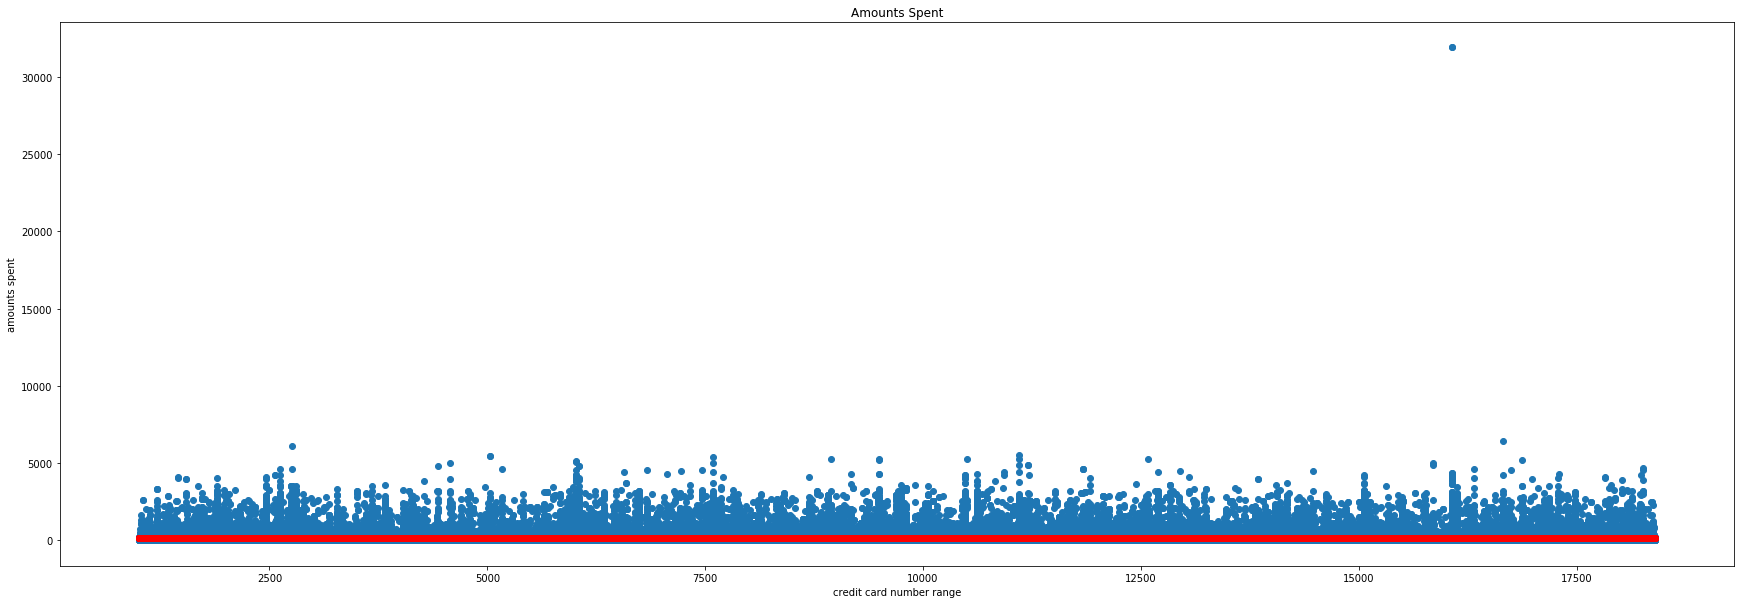

In [13]:
fig,ax=plt.subplots()
fig.set_size_inches(30,10)
ax.scatter(x=df['credit_card_number'], 
           y=df['amount_spent'])
ax.scatter(x=df['credit_card_number'], 
           y=mean_values, 
           c='red', 
           linestyle='-', 
           linewidths=0.5, 
           label='mean')
plt.title('Amounts Spent')
plt.xlabel('credit card number range')
plt.ylabel('amounts spent')
plt.show()

Innerhalb des Scatter Plots ist zu entnehmen, dass ein Ausreiser vorhanden ist. Im Folgenden wird dessen genauer Wert nochmals ermittelt und aus dem Datensatz entfernt, da dieser eher die Ausnahme als die Regel zu sein scheint.

In [14]:
max_v=df['amount_spent'].max()
index=df[df['amount_spent'] == max_v].index
df.drop(index=index, inplace=True)

In [15]:
mean_values=[]
mean_value=df['amount_spent'].agg('mean')
for i in range(0,len(df['amount_spent'])):
    mean_values.append(mean_value)

Nachdem der offensichtliche Ausreiser entfernt wurde, werden die Daten nochmals mit einem Scatter Plot visualisiert.

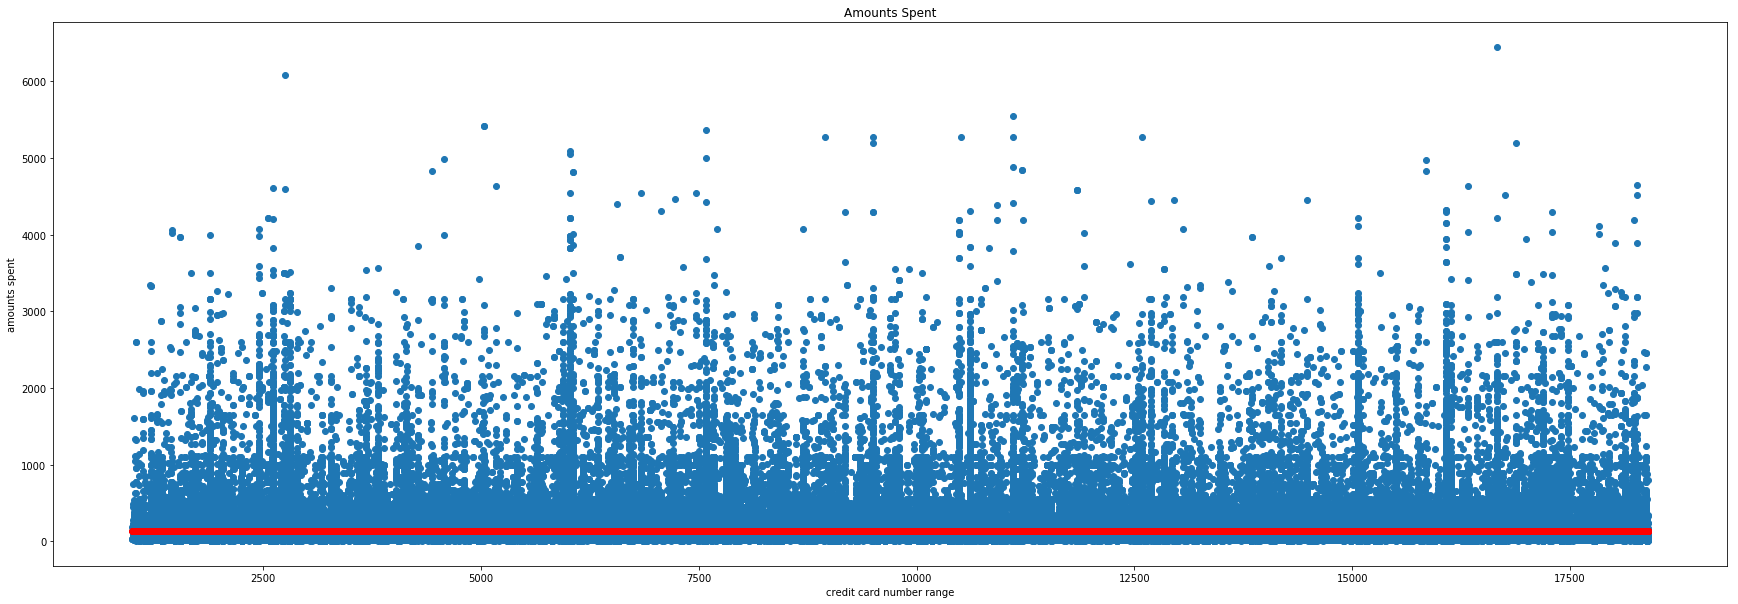

In [16]:
fig,ax=plt.subplots()
fig.set_size_inches(30,10)
ax.scatter(x=df['credit_card_number'], 
           y=df['amount_spent'])
ax.scatter(x=df['credit_card_number'], 
           y=mean_values, 
           c='red', linestyle='-', 
           linewidths=0.5, 
           label='mean')
plt.title('Amounts Spent')
plt.xlabel('credit card number range')
plt.ylabel('amounts spent')
plt.show()

Im weiteren Verlauf werden keine weiteren Daten aus dem Datensatz entfernt, da dies möglicherweise die Realität verzerren könnte.

## K-Means Clustering
Im folgenden wird nun das K-Means Clustering vorgenommen. Dafür muss zunächst die Anzahl der Cluster definiert werden. Daran anschließend wird die <code>execution_role</code> ermittelt.

In [17]:
num_clusters=3
role = get_execution_role()

Sind diese beiden Variablen definiert, kann das <code>KMeans</code> Objekt des <code>sagemaker</code> Python Packages initialisiert werden. Dieses wird mit folgenden Parametern initialisiert:
* der ausführenden Rolle
* der Anzahl der Maschinen, die das Training des Models durchführen sollen
* dem Typ der Maschine
* dem S3 Bucket Pfad in dem das trainierte Model gespeichert werden soll
* der Anzahl der zu bildenen Cluster

In [18]:
kmeans = KMeans(role=role,
                train_instance_count=1,
                train_instance_type='ml.c4.xlarge',
                output_path='s3://'+ bucket_name +'/result/',              
                k=num_clusters)

Daran anschließend werden aus dem DataFrame bis auf <code>amount_spent</code> alle Spalten gelöscht, da nur Cluster über den ausgegebenen Betrag gebildet werden sollen.

In [19]:
train_df=df.drop(columns=['credit_card_number', 
                         'transaction_id', 
                         'transaction_is_fraudulent', 
                         'transaction_time_delta', 
                         'credit_card_holder', 
                         'credit_card_expiration_date', 
                         'crdeit_card_validation_code_two'])

Mit diesem neuen DataFrame kann nun das Model trainiert werden.

In [20]:
%%time
train_d=train_df.values.astype('float32')
kmeans.fit(kmeans.record_set(train_d))

2020-01-26 10:32:01 Starting - Starting the training job...
2020-01-26 10:32:03 Starting - Launching requested ML instances...
2020-01-26 10:33:00 Starting - Preparing the instances for training.........
2020-01-26 10:34:30 Downloading - Downloading input data...
2020-01-26 10:35:00 Training - Training image download completed. Training in progress.
2020-01-26 10:35:00 Uploading - Uploading generated training model
2020-01-26 10:35:00 Completed - Training job completed
Docker entrypoint called with argument(s): train
[01/26/2020 10:34:51 INFO 140232795359040] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local

In [21]:
%%time
kmeans_predictor = kmeans.deploy(initial_instance_count=1,
                                 use_compiled_model=False,
                                 instance_type='ml.t2.medium')

-----------------!CPU times: user 277 ms, sys: 12.5 ms, total: 289 ms
Wall time: 8min 32s


In [140]:
clusters_df = pd.DataFrame(columns=['credit_card', 'transaction_id', 'amount_spent', 'belonging_to_cluster'])

In [142]:
credit_cards = df.credit_card_number.unique()
for credit_card in credit_cards:
    tmp = df[(df['credit_card_number'] == credit_card)]
    t_ids = tmp['transaction_id']
    amounts_spent = tmp['amount_spent']
    for t_id in t_ids:
        amount = tmp[(tmp['transaction_id'] == t_id)]['amount_spent'].values.astype('float32')
        value_result = kmeans_predictor.predict(amount)
        clusters_df = clusters_df.append(pd.Series([credit_card, t_id, amount[0], value_result[0].label['closest_cluster'].float32_tensor.values[0]], index=clusters_df.columns), ignore_index=True)
        
clusters_df.head()

,credit_card,transaction_id,amount_spent,belonging_to_cluster
0,1000.0,3230924.0,23.443001,0.0
1,1001.0,3023634.0,183.000000,0.0
2,1001.0,3210739.0,27.000000,0.0
3,1001.0,3151336.0,29.000000,0.0
4,1004.0,3504379.0,226.000000,0.0


In [147]:
clusters_df.to_csv(path_or_buf='clustering_result.csv', index=False)

In [150]:
s3_client.upload_file('clustering_result.csv', bucket_name, 'data/clustering_result.csv')

In [36]:
job_name = "kmeans-2020-01-26-10-32-01-560"
model_key = "result/" + job_name + "/output/model.tar.gz"

boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

2304

In [37]:
!pip install mxnet

    100% |████████████████████████████████| 25.4MB 2.0MB/s eta 0:00:01
    100% |████████████████████████████████| 20.2MB 3.4MB/s eta 0:00:01
  Found existing installation: numpy 1.14.3
    Uninstalling numpy-1.14.3:
      Successfully uninstalled numpy-1.14.3
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [126]:
import mxnet as mx
Kmeans_model_params = mx.ndarray.load('model_algo-1')
print(Kmeans_model_params[0].asnumpy())

[[  79.10452]
 [1408.194  ]
 [ 401.63287]]
